## Writeup Template

**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


In [1]:
# Necessary imports
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split


C:\Users\shaurya.dwivedi\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)



### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.


* I started by reading in all the `vehicle` and `non-vehicle` images from the data set provided by udacity.

* I've used all the images from vehicles and non-vehicles.

* I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`,  and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

* I tried different orientations from 8-11 and pixels per cell as 8,16 and 32 while trying different orientations the results were fluctuating a lot. 

#### 2. Explain how you settled on your final choice of HOG parameters.

* I tried various combinations of parameters and finally settled with orintation as 9, pixels per cell as 8 and cells per block as 2 which gave the accuracy of my linear svc as 98%.

* While trying different combinations, the test accuracy of my model was fluctuating but after using above combination of parameters i got the accuracy of more than 98% which is pretty decent.

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

* I trained a linear SVM using the combination of spatial bin, color histogram and HOG with bin size as 16 and spatial size as (32,32).

* I created the vertical feature stack for the cars and not car images.

* Then i created labels as 1 for the cars and 0 for the non cars.

* I splitted the data as 80-20 for traning and tesing and scaled the per column values of training data to avoid overfitting.

* Finally i trained linear SVC as it's pretty fast to train, gives decent accuracy and does the job as well.

In [2]:
# Convert color of the image
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Generate hog features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Generate spatial bin
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Generate color histogram
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [3]:
# Read in cars and notcars
vehicles = glob.glob('../vehicles/vehicles/*/*.png')
nonvehicles = glob.glob('../non-vehicles/non-vehicles/*/*.png')
print(len(vehicles))
cars = []
notcars = []
for image in nonvehicles:
    notcars.append(image)
for image1 in vehicles:
    cars.append(image1)
    

print(len(cars))


8792
8792
8792


...


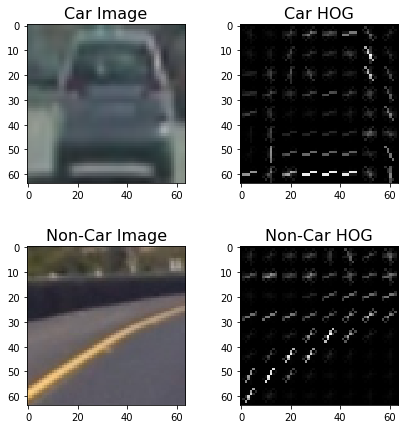

In [26]:
car_img = mpimg.imread(cars[5])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = mpimg.imread(notcars[5])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)
print('...')

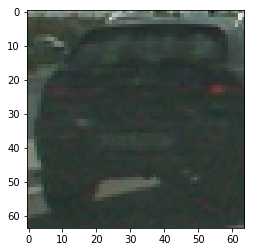

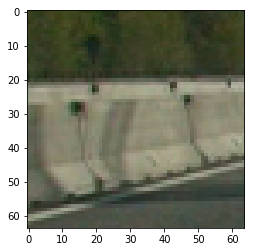

In [23]:
# Selecting random car
car = np.random.randint(0, len(cars))
ncar = np.random.randint(0, len(notcars))
    
# Display
car_image = mpimg.imread(cars[car])
ncar_image = mpimg.imread(notcars[ncar])
plt.imshow(car_image)
plt.show()
plt.imshow(ncar_image)


In [5]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 650] # Min and max in y to search in slide_window()
ystart = 400
ystop = 650
scale = 1.5

#### Feature Extraction
* Here the feature extraction is done using spatial bin, color histograms and HOG

In [6]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    


In [7]:
# Extracting car features
t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Extracting not car features
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')
print(len(car_features))
print(len(notcar_features))

137.5 Seconds to extract features...
8792
8968


In [8]:

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108


In [9]:
# Use a linear SVC 
from sklearn.svm import SVC
#svc = SVC(kernel="linear")
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
#pred=svc.predict(X_test)
#print("Prediction value is ",pred)
t=time.time()

25.44 Seconds to train SVC...
Test Accuracy of SVC =  0.9837


In [10]:

from scipy.ndimage.measurements import label

# Add heat to the pixels
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

# Apply threshold to reduce false positive
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Draw labelled boxes
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

* I used HOG sub-smapling because it only has to extract hog features once, for each of a small set of predetermined window sizes (defined by a scale argument), and then can be sub-sampled to get all of its overlaying windows.

* Each window is defined by a scaling factor that impacts the window size. The scale factor can be set on different regions of the image (e.g. small near the horizon, larger in the center). 

* I used 1.5 scale to impact the window size.

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

* Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.

* Images can be found below as output.

In [24]:

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    bboxes=[]
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
      
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img,bboxes
    
ystart =350
ystop = 656
xstart= 450
xstop=1280
scale = 1.5
    


In [21]:
# import
from collections import deque
# Variable to store heat to reduce false positive
avg_heat=deque(maxlen=20)

# Process pipeline
def pipeline(image):
    draw_img1=np.copy(image)
    out_img,bboxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    out_img1,bboxes1 = find_cars(image, 390, 480, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.extend(bboxes1)
    
    # Add heat to each box in box list
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,bboxes)
    
    # Apply threshold to help remove false positives
    avg_heat.append(heat)
    heatmap=np.sum(avg_heat,axis=0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heatmap, 0,255)
    heatmap = apply_threshold(heatmap,40)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img1 = draw_labeled_bboxes(draw_img1, labels)
    
    return draw_img1


In [17]:
#import 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

6


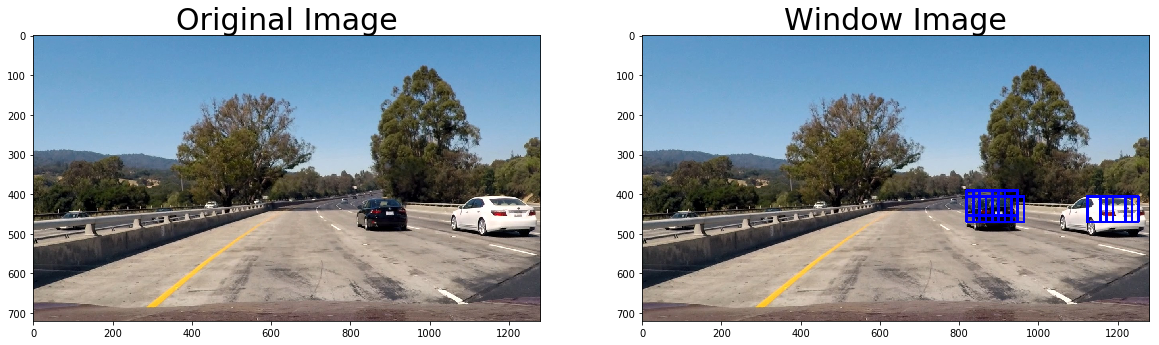

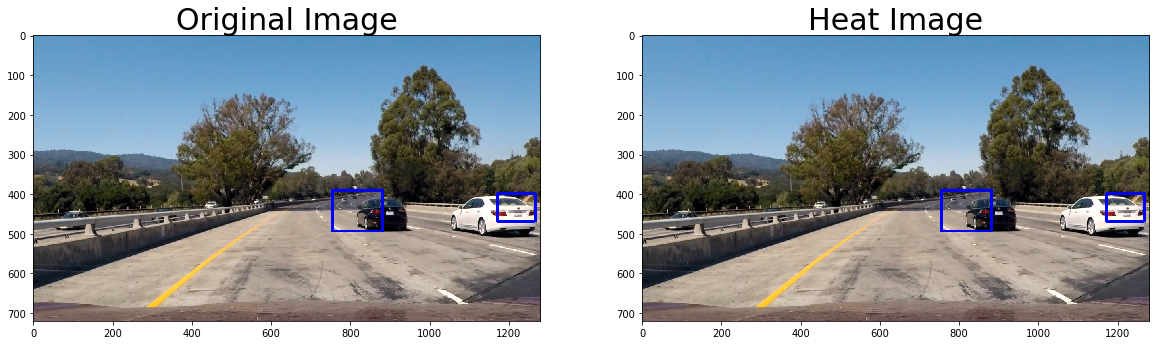

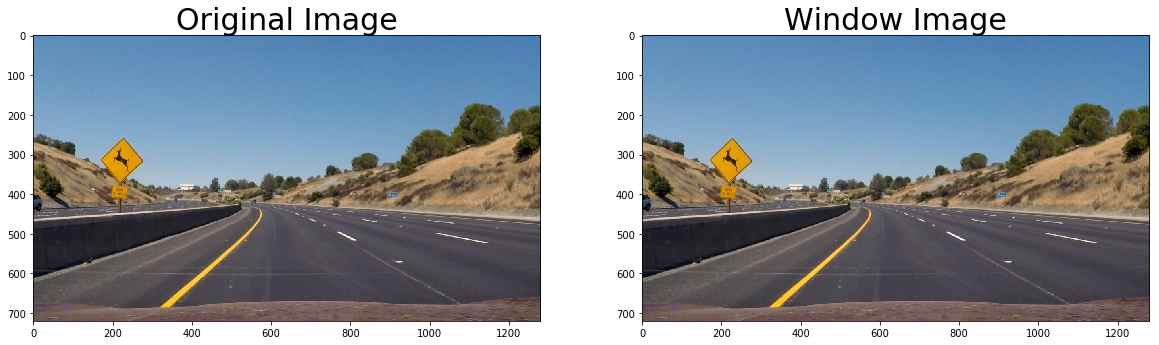

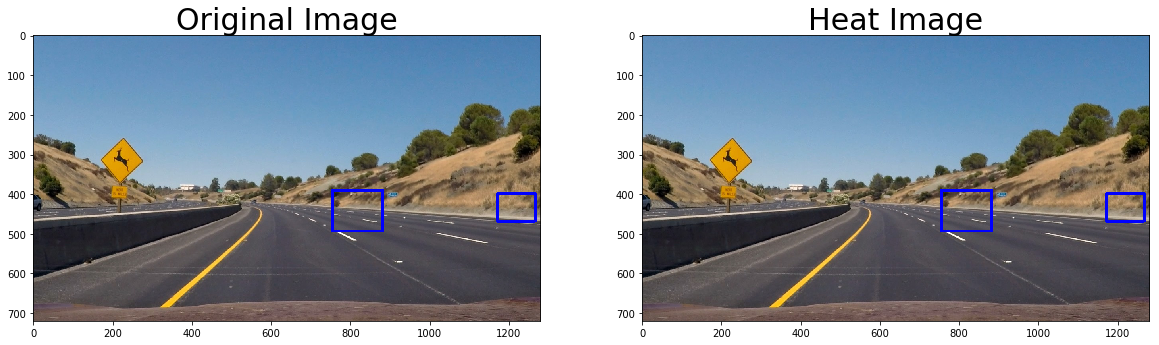

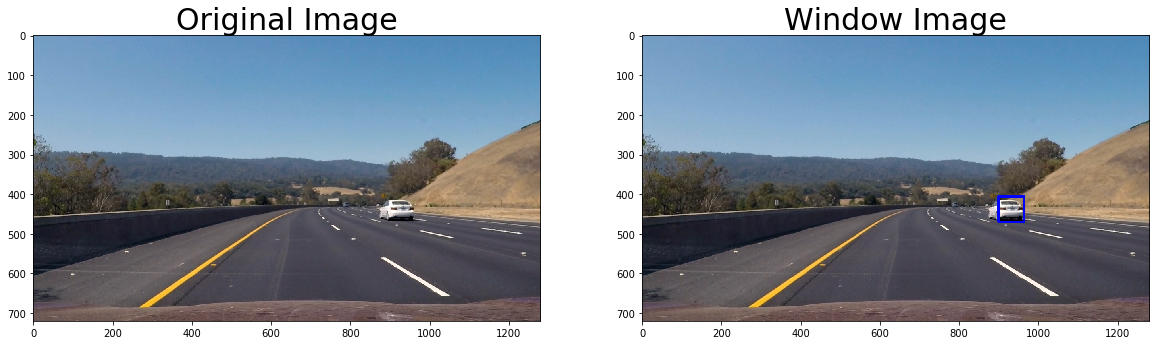

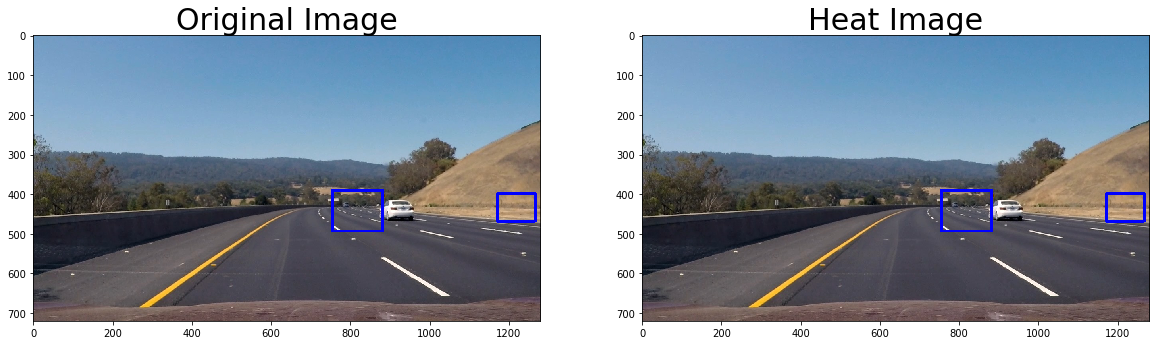

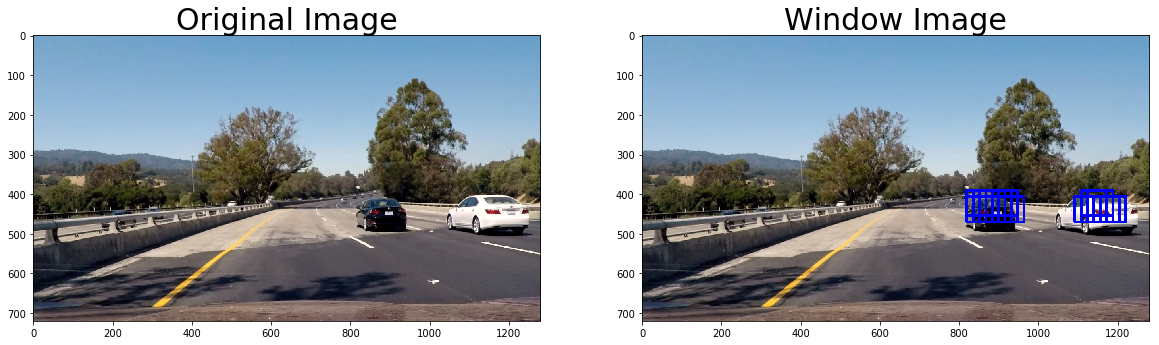

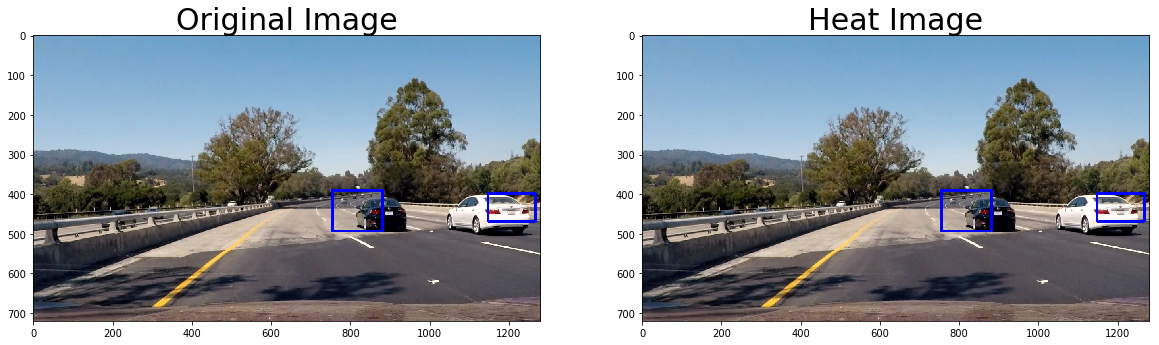

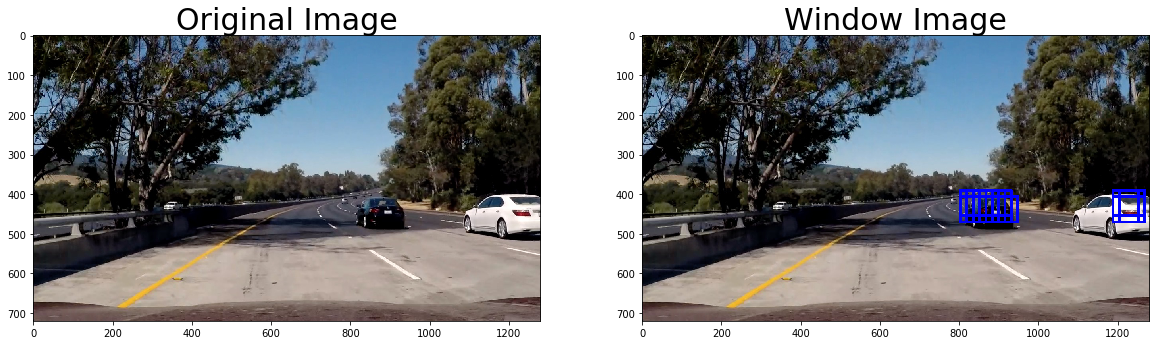

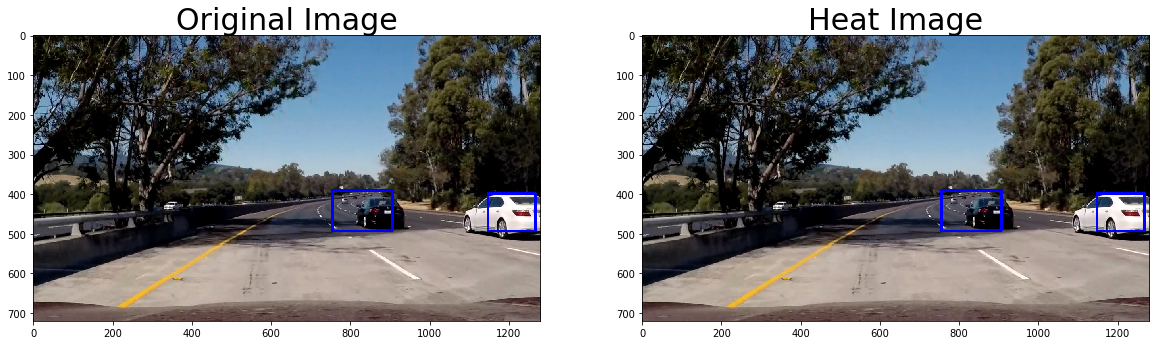

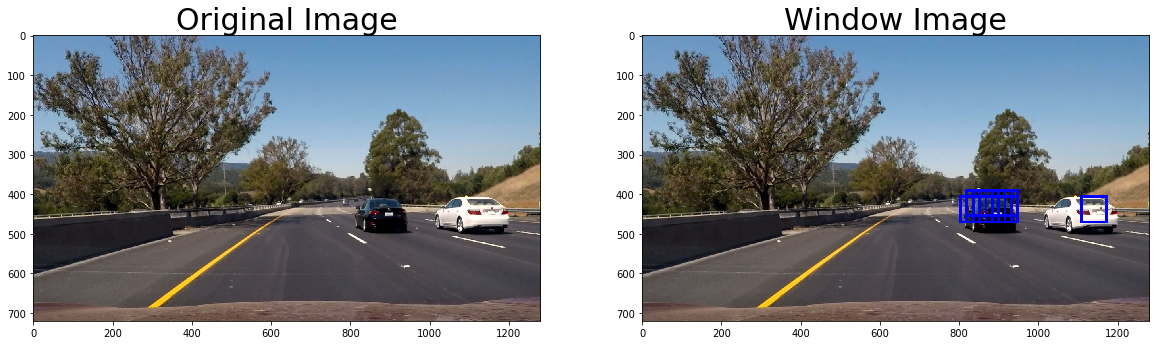

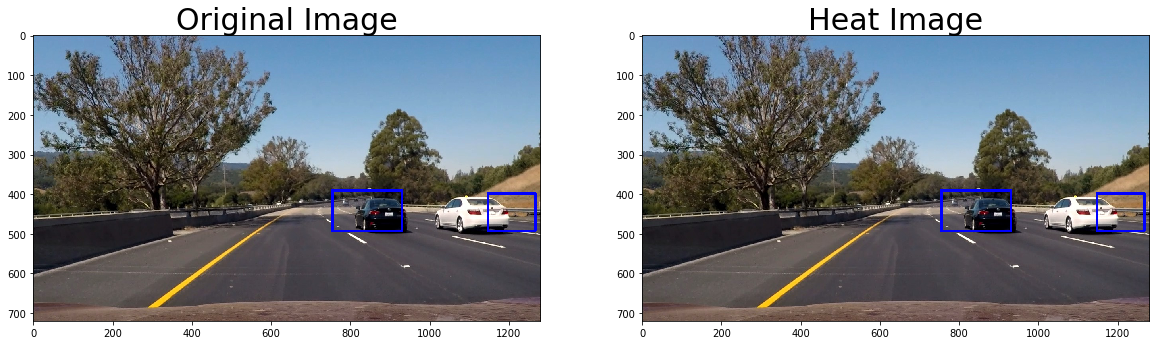

In [22]:
#Reading test images
test_images = [mpimg.imread(img) for img in glob.glob("test_images/*.jpg")]
print(len(test_images))

# Plotting test images
for img in test_images:
    plt.imshow(pipeline(img))
    plt.show()

### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
* Here's a [link to my video result](./projectFinal_video2.mp4)


#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

* I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  
* The inages can be found above. Due to hardware restrictions i have generated minimum images so that the idea can be plotted.

In [27]:
# Output video
white_output = 'testvideo_output/projectFinal_video2.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

OSError: [WinError 6] The handle is invalid


### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

* The basic problem was to identify the correct set of parameters that can work. I tried HSV color space which gave me almost 100% accuracy but the result while drawing the labelled boxes wasn't as desired.
* The other issue was 'False Positives', to avoid that i used heat map to reduce the unnecessary detections and also summed up the 20 frames for false positive reduction.
* This pipeline might fail on the images under various lightning conditions and angles. Haven't tried yet but gonna check it's limitation.
* To make it more robust we can use different color channel combinations as well with different SVM kernels say 'rbf'.
* The other approach might be to use CNN in place of the classifier. Gonna try that too. :)